Like Tensorflow, PyTorch has a number of datasets included in the package (including Text, Image, and Audio datasets). The deep learning part of this tutorial will use one of these built-in image datasets: CIFAR10. These datasets are very common, and widely documented around the ML community, so they are great for prototyping and benchmarking models, since you can compare the performance of your model to what others were able to achieve with theirs.

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST # torchvision for image datasets
from torchtext.datasets import AmazonReviewFull # torchtext for text
from torchaudio.datasets import SPEECHCOMMANDS #torchaudio for audio
import warnings
warnings.filterwarnings('ignore')

training_data = FashionMNIST(
    # the directory you want to store the dataset, can be a string e.g. "data"
    root = 'data', 
    # if set to False, will give you the test set instead
    train = True, 
    # download the dataset if it's not already available in the root path you specified
    download = True, 
    # as the name implies, will transform images to tensor data structures so PyTorch can use them for training
    transform = torchvision.transforms.ToTensor() 
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



With this, if your dataset has labels or classifications, you can quickly view a list of those:

In [2]:
training_data.classes
# ['T-shirt/top',
# 'Trouser',
# 'Pullover',
# 'Dress',
# 'Coat',
# 'Sandal',
# 'Shirt',
# 'Sneaker',
# 'Bag',
# 'Ankle boot']

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [3]:
training_data.class_to_idx # get the corresponding index with each class
# {'Ankle boot': 9,
# 'Bag': 8,
# 'Coat': 4,
# 'Dress': 3,
# 'Pullover': 2,
# 'Sandal': 5,
# 'Shirt': 6,
# 'Sneaker': 7,
# 'T-shirt/top': 0,
# 'Trouser': 1}

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Now obviously built-in datasets will not be all you need as a machine learning practitioner. Although the process will be more complex than just importing a dataset, creating your own dataset with PyTorch is fairly easy and flexible. This is somewhat beyond the scope of this post, but I’ll post an in-depth guide to creating datasets in the near-future.

# <b> DataLoader <b>
Iterating through the dataset will go through each sample 1 by 1, so PyTorch gives us the DataLoader module to easily create minibatches in our datasets. DataLoader allows us to specify the batch_size as well as shuffle the data:

In [4]:
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)

So in your deep learning workflow, you’ll want to feed your data to your model for training through DataLoader in minibatches.

The deep learning portion of the tutorial will demonstrate working with the DataLoader and feeding it to a neural network.

One final important feature before we move on to Deep Learning is setting the device. When you want to train on a GPU you can check if a GPU is available for PyTorch to use:

In [5]:
torch.cuda.is_available()
# True if GPU available

True

PyTorch defaults to the CPU, so even with a GPU on hand, you still need to specify that you want to use the GPU for training. If you are certain your GPU is available, you can use .to(“cuda”) on your tensors and models. Otherwise, you might consider setting a device variable to whatever device is available:

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
# 'cuda'

# you can specify .to("cuda") or .to(device)
# tensor = tensor.to("cuda")

# attaching your neural network model to your GPU
# model = model.to(device)

Device: cuda


If you are using Google Colab, you will have access to a GPU for free (unless you want to subscribe). Speaking of Colab, let’s move on to the setup for our classification task!

# <b>Setup </b>
    
For this tutorial, we will be using Google Colab. Colab has been my go-to for all of my machine learning projects, because there is no easier setup, in my opinion. Obviously, some projects will require a different setup, but for smaller projects and tutorials, you can’t really beat Colab’s free GPU access and environment that already includes packages like PyTorch, NumPy, Scikit-Learn already installed.

So to start, navigate to the Google Colab page, and sign in with your Google account. File > New notebook. Change the name of your notebook at the top to pytorchIntro.ipynb , or something else if you'd prefer. Colab doesn't give you an instance with GPU access by default, so you have to specify you want to use a GPU: at the top, go to Runtime > Change runtime type > Hardware accelerator > Select "GPU" > Save. Now you have a GPU to train your models!

If you’re curious about the GPU that you’ll be using, type !nvidia-smi and execute that line by hitting the Play button on the left of the line, or by pressing Shift+Enter. You can also run !nvidia-smi -L if all you want is the GPU device:

Now that you have Colab up, and a GPU ready to train your model, let’s get to the code.



In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize, Compose
import os
import matplotlib.pyplot as plt
import numpy as np

Add these imports to your first line, and execute that line. These are the main PyTorch modules we will be using, along with a few support imports. We will go over these in a little more detail when we use them.

# <b> Dataset </b>
CIFAR-10 dataset
This dataset consists of 60,000 32x32 color images, all labeled as one of 10 classes. The training set is 50,000 images, while the test set is 10,000.

Here is a nice visualization of the dataset from the home source:

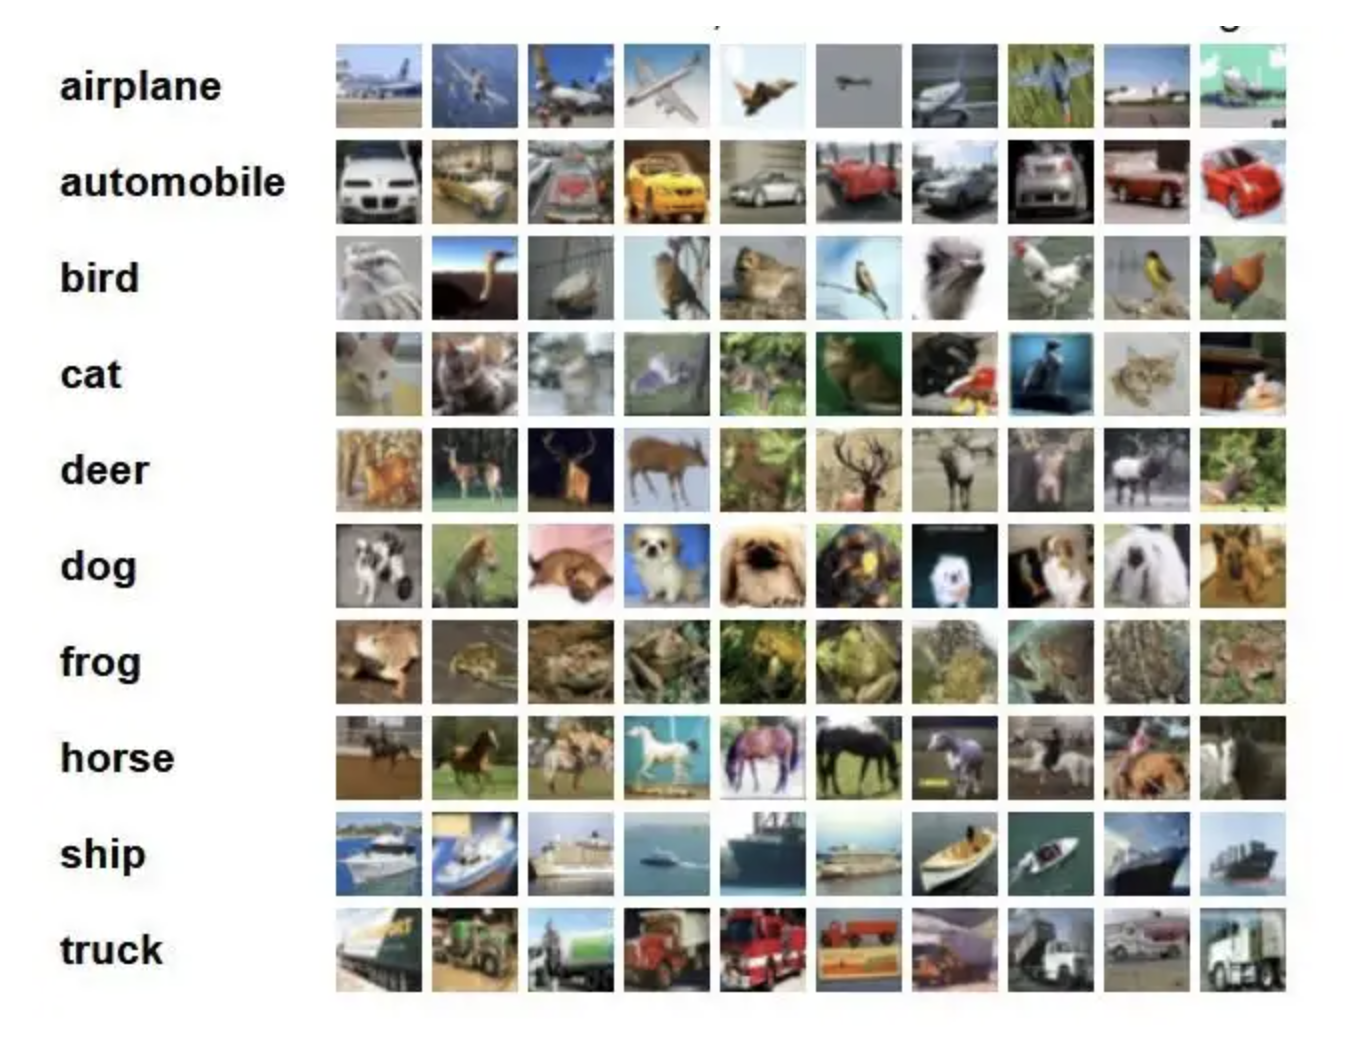

The goal for this project will be to build a model that can accurately classify images as one of the 10 classifications.

# <b> Loading the dataset </b>
So we imported CIFAR10 from torchvision, and now we need to download the actual dataset, and prepare it to be loaded into the neural network.

First, since we should normalize our images before feeding them to the model, we will define a transform function, and use torchvision.transforms.Normalize to normalize all of our images when we create the training and test data variables. The Normalize method takes the desired mean and standard deviation as agruments, and since these are color images, a value should be provided for each (R, G, B) color channel.

We will set the values here to 0.5, since we would like to have the values of our image data to be close to 0, but there are other, more precise approaches to normalization.



In [8]:
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5),  # mean
               (0.5, 0.5, 0.5))] # std. deviation
)

Now we can use our transform function in the transform argument so that PyTorch will apply this to the entire dataset.

In [9]:
training_data = CIFAR10(root="cifar",
                        train = True, # train set, 50k images
                        download = True,
                        transform=transform)
test_data = CIFAR10(root = "cifar",
                    train = False, # test set, 10k images
                    download = True,
                    transform = transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


Now that we have our dataset downloaded and normalized, we can prepare it to get fed to the neural network by using the PyTorch DataLoader, where we can define the batch_size.

In [10]:
batch_size = 4
train_dataloader = DataLoader(training_data, 
                              batch_size=batch_size, 
                              shuffle=True)
test_dataloader = DataLoader(test_data, 
                             batch_size=batch_size, 
                             shuffle=True)

DataLoader is an iterable, so let's take a look at train_dataloader by checking out the dimensions of one iteration:



In [11]:
for X, y in train_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break
# Shape of X [N, C, H, W]: torch.Size([4, 3, 32, 32])
# Shape of y: torch.Size([4]) torch.int64

Shape of X [N, C, H, W]: torch.Size([4, 3, 32, 32])
Shape of y: torch.Size([4]) torch.int64


Here X is the images, and y is the labels. We set batch_size = 4 so each iteration through our train_dataloader is a mini-batch of 4 32x32 images and their 4 corresponding labels.

Now let’s take a peak at some examples in our dataset.



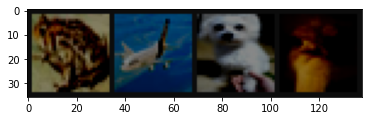

frog  airplane dog   bird 


In [12]:
import warnings
warnings.filterwarnings('ignore')
def imshow(img):
  img = img / 2 + .05 # revert normalization for viewing
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()
  
classes = training_data.classes
training_data.classes
#['airplane',
# 'automobile',
# 'bird',
# 'cat',
# 'deer',
# 'dog',
# 'frog',
# 'horse',
# 'ship',
# 'truck']

dataiter = iter(train_dataloader)
images, labels = next(dataiter)
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Now we can see a few images and their corresponding labels. Normally you would want to conduct more thorough data exploration and analysis before moving on to model building, but since this is just an introduction to PyTorch we will move on to building and training the model.

# <b> Defining the Base Model </b>
Let’s build a neural network.

First, we will define our model class, and name it NeuralNetwork. Our model will be a subclass of the PyTorch nn.Module, which is the base class for all neural network modules in PyTorch.

Since we have color images in our dataset, the shape of each image is (3, 32, 32), a 32x32 tensor in each of the 3 RGB color channels. Since our initial model will consist of fully-connected layers, we will need to nn.Flatten() our input image data. Our flatten method will output a linear layer with 3072 (32 x 32 x 3) nodes. nn.Linear() takes the number of input neurons and the number of outputs as arguments, respectively (nn.Linear(1024 in, 512 out)). From here you can add Linear layers and ReLU layers to your heart's content! The output of our model is 10 logits corresponding to the 10 classes in our dataset.

After we define the structure of the model, we will define the sequence of the forward pass. Since our model is a simple sequential model, our forward method will be really straightforward. The forward method will compute an output Tensor from input Tensors.

If you’d like to, you can simply print model once it's defined, so you can get a summary of the structure.

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        
model = NeuralNetwork().to(device)

print(model)
#NeuralNetwork(
#  (flatten): Flatten(start_dim=1, end_dim=-1)
#  (linear_relu_stack): Sequential(
#    (0): Linear(in_features=3072, out_features=1024, bias=True)
#    (1): ReLU()
#    (2): Linear(in_features=1024, out_features=512, bias=True)
#    (3): ReLU()
#    (4): Linear(in_features=512, out_features=10, bias=True)
#  )
#)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# <b> Loss function and Optimizer </b>
Since this is a classification problem, we will use the Cross-Entropy loss function. As a reminder, Cross-Entropy computes the log loss when the model outputs a predicted probability value betweeen 0 and 1. So as the predicted probability diverges from the true value, the loss increases rapidly (predictions that are wrong are penalized more if they are more confident). The graph below illustrates the behavior of the loss function as the predicted value gets closer and further from the true value.

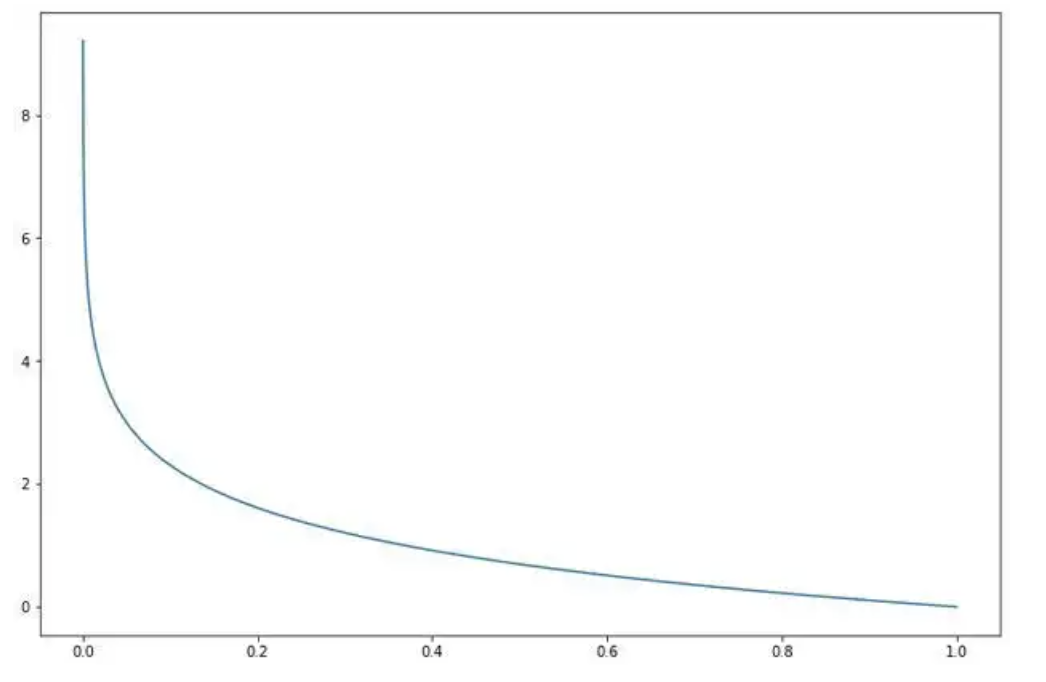


With PyTorch, we can just use CrossEntropyLoss(). For other ML tasks, you can use different loss functions if they are more fitting. For our optimization algorithm, we will use stochastic gradient descent, which is implemented in the torch.optim package, along with other optimizers like Adam and RMSprop. We just need to pass the parameters of our model, and the learning rate lr. If you want to use momentum or weight decay in your model optimization, you can pass that to the SGD() optimizer as well with the momentum and weight_decay parameters (both default to 0).

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(), lr=0.001 ) # momentum=0.9

# <b> Defining the Training Loop </b>
Here we define our train() function, where we will pass train_dataloader, model, loss_fn, and optimizer as arguments during the training process. The size variable is the length of the entire training dataset (50k). On the next line, model.train() is a PyTorch nn.Module method that sets the model to training mode, enabling certain behaviors that you would want during training (e.g. dropout, batch norm, etc.). In contrast (and as you'll see when we define our test function), you'd use model.eval() if you want to test your models performance. Next, we'll iterate through each mini-batch, specifying we'd like to utilize the GPU with to(device). We feed the mini-batch to our model, compute the loss, then backpropagate.

Backpropagation and Training Progress Output
For the backprop step, we need to run optimizer.zero_grad() first. This sets gradient to zero before starting backprop, since we dont want to accumulate the gradient over subsequent passes (this behavior can be desired in some cases, like RNNs where you want gradient accumulation). loss.backward() uses the loss to compute the gradient, then we use optimizer.step() to update the weights. Finally, we can print out updates to the training process, outputting the computed loss after every 2000 training samples.


In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 2000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# <b> Defining the Testing Method </b>
Before training the model, let’s implement the test function, so we can evaluate our model after every epoch, and output the accuracy on the test set. The big differences with the test method are that we use model.eval() to set the model into testing mode, and torch.no_grad() which will disable gradient calculation, since we don't use backpropagation during testing. Finally, we calculate the average loss for the test set and the overall accuracy.



In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# <b> Training our Model </b>
Now that we have the dataset loaded and pre-processed, the neural network built out, and the loss function/optimizer/training loop defined… we’re ready to train! Specify the number of epochs that you want to train the model for. Each epoch will go through a train loop, which outputs progress every 2000 samples, then it will test the model on the test set, and output the accuracy and loss on the test set after each epoch.

In [17]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.255070  [    0/50000]
loss: 2.158993  [ 8000/50000]
loss: 1.702831  [16000/50000]
loss: 2.052072  [24000/50000]
loss: 2.437422  [32000/50000]
loss: 2.479984  [40000/50000]
loss: 1.306415  [48000/50000]
Test Error: 
 Accuracy: 39.4%, Avg loss: 1.711802 

Epoch 2
-------------------------------
loss: 1.767794  [    0/50000]
loss: 1.307007  [ 8000/50000]
loss: 2.112957  [16000/50000]
loss: 1.742371  [24000/50000]
loss: 1.440334  [32000/50000]
loss: 1.186271  [40000/50000]
loss: 1.921291  [48000/50000]
Test Error: 
 Accuracy: 44.7%, Avg loss: 1.573101 

Epoch 3
-------------------------------
loss: 1.842229  [    0/50000]
loss: 1.796610  [ 8000/50000]
loss: 2.742060  [16000/50000]
loss: 1.251371  [24000/50000]
loss: 1.128504  [32000/50000]
loss: 1.779014  [40000/50000]
loss: 1.710369  [48000/50000]
Test Error: 
 Accuracy: 47.4%, Avg loss: 1.494117 

Epoch 4
-------------------------------
loss: 1.737603  [    0/50000]
loss: 2.023637  [ 8000/5

# <b> Saving and Loading a Model </b>
After training finishes, if you’d like to save your model to use for inference, use torch.save(). Pass model.state_dict() as the first argument; this is just a Python dictionary object which maps layers to their respective learned parameters (weights and biases). For the second argument, name your saved model (it's common convention to save PyTorch models using .pth or .pt extensions). You can also specify a full path for this argument if you prefer to save it in a specific location.

In [24]:
torch.save(model.state_dict(), "cifar_10.pth")

When you want to load your model for inference, use torch.load() to grab your saved model, and map the learned parameters with load_state_dict.

In [25]:
model = NeuralNetwork()
model.load_state_dict(torch.load("cifar_10.pth"))

<All keys matched successfully>

# <b> Evaluating the Model </b>
You can iterate through the test_dataloader to check out a sample of images with their labels.


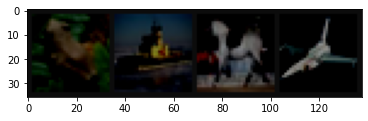

Ground Truth:  frog  ship  horse airplane


In [26]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

imshow(make_grid(images))
print('Ground Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Then compare it to our model’s predicted labels to get a preview of it’s performance:

In [27]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
# Predicted:  dog   ship  automobile deer

Predicted:  deer  ship  cat   airplane


So we can see, our model seems like it’s learning to classify! Let’s see the numbers for our model’s performance.

In [28]:

correct = 0
total = 0

with torch.no_grad():
   for data in test_dataloader:
     images, labels = data
     outputs = model(images)
     _, predicted = torch.max(outputs.data, 1)
     total += labels.size(0)
     correct += (predicted == labels).sum().item()
     
print(f'Model accuracy: {100 * correct // total} %')
# Model accuracy: 53 %

Model accuracy: 53 %


Accuracy of 53% is not state-of-the-art, but it’s much better than randomly guessing or just predicting one class, so our model has definitely learned some! :)

Next, we can quickly check out how it performed at classifying each class:

In [29]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0  for classname in classes}

with torch.no_grad():
  for data in test_dataloader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    for label,prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')
# Accuracy for class airplane: 58.9%
# Accuracy for class automobile: 61.2%
# Accuracy for class bird : 33.5%
# Accuracy for class cat  : 35.4%
# Accuracy for class deer : 52.8%
# Accuracy for class dog  : 49.4%
# Accuracy for class frog : 60.6%
# Accuracy for class horse: 59.6%
# Accuracy for class ship : 64.5%
# Accuracy for class truck: 63.1%

Accuracy for class airplane: 55.0%
Accuracy for class automobile: 60.1%
Accuracy for class bird : 41.0%
Accuracy for class cat  : 36.4%
Accuracy for class deer : 50.6%
Accuracy for class dog  : 34.3%
Accuracy for class frog : 62.8%
Accuracy for class horse: 62.9%
Accuracy for class ship : 70.2%
Accuracy for class truck: 64.7%
